To Do:

        # - - - - - - To Do: - - - - - - 
        #    
        #    Preprocessing
        #    
        #    
        #    
        #    Supervised
        #    
        #    
        #    Unsupervised
        #    
        #    
        #    
        #    Plots
        #    
        #    Document Like Scikit source
        #  
        #    Pep8
        #  
        #    Try TSNE instead of PCA
        #  
        #    Import Dynamic Time Warp Method from Riverside
        #    
        #    Try Using other Clustering Methods
    
        

To Examine:

    Mixed Dimension PCA
    
    Explained Variance from PCA

    Make an Analogous "Which method works best" to run similar to the UCR program. (And try loads of them)

    Test things with Time-It.

    Laplace Analysis 
    
    


In [107]:
import numpy as np
from scipy import signal
from scipy.stats import linregress
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import csv
import re
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from scipy.signal import blackman
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.externals import joblib
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
           

style.use('ggplot')


In [130]:
train_data = np.genfromtxt('FordA_TRAIN', delimiter=',')[:,1:]
train_classes=np.genfromtxt('FordA_TRAIN', delimiter=',')[:,0]

test_data = np.genfromtxt('FordA_TEST', delimiter=',')[:,1:]
test_classes=np.genfromtxt('FordA_TEST', delimiter=',')[:,0]

In [129]:
train_data.shape[0]

1320

In [150]:
class TimeSeriesClassifier:
    # TimeSeriesClassifier takes a data input which is an m x n numpy array where each column is a time series with m entries
    # The reason for this Class is to avoid computing the fft 100 times during play, as well as to avoid
    # any unnecessary computation. Roughly, it serves as an organized record of the operations you have had to do.
    # hopefully the procedures written will take into account any required operation that hasn't been computed, and compute it
    # This will save a bit of thinking and button pressing. 
    def __init__(self,data,classes):
        
        
        
        #Time Series Array
        self.data=data
        #Time Series Classes (if classified, otherwise just pass None)
        self.classes=classes
        #Dimensions of Time Series Array
        self.sample_size=self.data.shape[0]
        self.series_size=self.data.shape[1]
        
        self.df=pd.DataFrame(self.data,index=['Sample No. '+str(x) for x in range(self.sample_size)],
                             columns=['Observation No. '+str(x) for x in range(self.series_size)])
        
        
        
        #Raw FFT of Each Time Series
        self.fft=np.array([])
        
        #Mean Value of Each Time Series
        self.mean=np.array([])
        
        #The linear term in a linear regression on each time series (i.e. scaled gain)
        self.slope=np.array([])
        
        #The intercepts from linreg on each time series
        self.intercept=np.array([])      
        
        #The rvalues from linreg on each time series
        self.rvalues=np.array([])        
        
        #The pval from linreg on each time series
        self.pvalues=np.array([])        
        
        #The stderr from linreg on each time series
        self.stderrors=np.array([])
        
        #Time Series array with linear trends removed, and "uniformly" scaled (divide by the mean value)
        self.detrend=np.array([])
        
        #FFT of windowed detrended time series
        self.adjusted_fft_windowed=np.array([])
        
        
        self.max=np.array([])
        self.min=np.array([])
        
        #Laplace Transform of Data
        self.laplace=np.array([])
        
        #Storage for a Continuous Wavelet Transform:
        self.cwt=np.array([])

        
        # PCA on FFT or adjusted FFT (try to get the transpose/not transpose correct)
        self.fft_pca=PCA()
        self.adj_fft_pca=PCA()
        
        #Arc Length Histogram
        self.arc=np.array([])
        
        self.pca_arc=PCA()
        #ElasticNetCV regression coefficients (or whatever other poly reg I like best...)
        self.elastic_net=np.array([])           
        
        #PCA on Raw Data
        self.pca=PCA()
        
    # FUNCTIONS:    
        
    #Return FFT of Each Time Series (Calculate if Needed)
    def get_fft(self):
        if self.fft.size == 0:
            self.fft=fft(self.data)
        return self.fft
        
        
    #Return Mean Value of Each Time Series
    def get_mean(self):
        if self.mean.size == 0:
            self.mean=np.mean(self.data,axis=1)
        return self.mean

        #Returns the linear term in a linear regression on each time series (i.e. scaled gain)
    def get_slope(self):
        if self.slope.size == 0:
            intercepts=np.zeros(self.sample_size)
            slopes=np.zeros(self.sample_size)
            rvals=np.zeros(self.sample_size)
            pvals=np.zeros(self.sample_size)
            stderrs=np.zeros(self.sample_size)
            for idx, row in zip(range(self.sample_size),self.data):
                s,i,r,p,st=linregress(range(self.series_size),row)
                intercepts[idx]=i
                slopes[idx]=s
                rvals[idx]=r
                pvals[idx]=p
                stderrs[idx]=st
            self.intercept=intercepts
            self.slope=slopes
            self.rvalues=rvals
            self.pvalues=pvals
            self.stderrors=stderrs
        return self.slope
        
        #Returns the intercepts from linreg on each time series
    def get_intercept(self):
        if self.intercept.size == 0:
            intercepts=np.zeros(self.sample_size)
            slopes=np.zeros(self.sample_size)
            rvals=np.zeros(self.sample_size)
            pvals=np.zeros(self.sample_size)
            stderrs=np.zeros(self.sample_size)
            for idx, row in zip(range(self.sample_size),self.data):
                s,i,r,p,st=linregress(range(self.series_size),row)
                intercepts[idx]=i
                slopes[idx]=s
                rvals[idx]=r
                pvals[idx]=p
                stderrs[idx]=st
            self.intercept=intercepts
            self.slope=slopes
            self.rvalues=rvals
            self.pvalues=pvals
            self.stderrors=stderrs
        return self.intercept
        
        #Time Series array with linear trends removed, and "uniformly" scaled (divide by the mean value)
    def get_detrend(self):
        if self.detrend.size==0:
            linout=self.data-(np.repeat(np.arange(self.series_size),self.sample_size).reshape([self.sample_size,self.series_size]).T\
            *self.get_slope()).T-np.repeat(self.get_intercept(),self.series_size).reshape([self.series_size,self.sample_size]).T
            self.detrend=linout/self.get_mean()[:,None]
        return self.detrend
                          
                                  
        #FFT of windowed detrended time series
    def get_adjusted_fft_windowed(self):
        if self.adjusted_fft_windowed.size==0:
            self.adjusted_fft_windowed=fft(self.get_detrend()*blackman(self.series_size))
        return self.adjusted_fft_windowed

    def get_max(self):
        if self.max.size==0:
            self.max=np.amax(self.data,axis=1)
        return self.max
    
    def get_min(self):
        if self.min.size==0:
            self.min=np.amin(self.data,axis=1)
        return self.min

        
        #Laplace Transform of Data
    def get_laplace(self):
        pass
    
        #Continuous Wavelet Transform:
    def get_cwt(self):
        pass
        #if self.cwt.size==0:
        #    self.cwt=np.zeros([self.size[1],500,500])
        #    for idx, col in zip(range(self.size[1]),self.data.T):
        #        self.cwt[idx]=signal.cwt(col, signal.ricker, np.arange(1,self.size[0]+1))
        #return self.cwt        

        # PCA on FFT or adjusted FFT (try to get the transpose/not transpose correct)

    def get_fft_pca(self):
        try:
            self.fft_pca.get_covariance()
        except:
            self.fft_pca.fit(self.get_fft())
        return self.fft_pca
    
    
    def get_adj_fft_pca(self):
        try:
            self.adj_fft_pca.get_covariance()
        except:
            self.adj_fft_pca.fit(self.adjusted_fft_windowed)
        return self.adj_fft_pca
    
    
        #Differences between points (Arc Length Approx)
    def get_arc(self):
        if self.arc.size==0:
            self.arc=self.data[:,1:]-self.data[:,0:-1]
        return self.arc   
        
        #ElasticNetCV regression coefficients (or whatever other poly reg I like best...)
    def get_elastic_net(self):
        if self.elastic_net.size==0:
            self.elastic_net=np.zeros(self.sample_size)
            el=ElasticNet(alpha=.01,l1_ratio=.25)
            for idx, col in zip(range(self.sample_size/10),self.data):
                el.fit(np.arange(self.series_size).reshape(-1,1),col)
            self.elastic_net[idx]=el.coef_
        return self.elastic_net  
        
        
        #PCA on Raw Data
    def get_pca(self):
        try:
            self.pca.get_covariance()
        except:
            self.pca.fit(self.data)
        return self.pca
    
            #PCA on arc/derivative
    def get_pca_arc(self):
        try:
            self.pca_arc.get_covariance()
        except:
            self.pca_arc.fit(self.get_arc())
        return self.pca_arc
        
        

In [151]:
TestClass=TimeSeriesClassifier(train_data,train_classes)

In [152]:
print(TestClass.df)

                 Observation No. 0  Observation No. 1  Observation No. 2  \
Sample No. 0             -0.140400           0.171640           0.302040   
Sample No. 1              0.334040           0.322250           0.453840   
Sample No. 2              0.716690           0.744370           0.725910   
Sample No. 3              1.240300           1.331200           1.386600   
Sample No. 4             -1.159500          -1.204200          -1.167600   
Sample No. 5              0.659020           0.325790           0.019658   
Sample No. 6             -0.357040          -0.349500          -0.478710   
Sample No. 7              0.012008           0.759680           1.301100   
Sample No. 8             -1.064300          -1.102700          -1.095800   
Sample No. 9             -1.196700          -0.930590          -0.608550   
Sample No. 10             3.527500           3.102200           2.623700   
Sample No. 11            -0.033265           0.250060           0.514420   
Sample No. 1

In [153]:
import pylab as pl
from sklearn import datasets

# load dataset
df = pd.DataFrame(TestClass.get_adjusted_fft_windowed())#, columns=[str(x) for x in range(500)])

# normalize data
data_scaled = pd.DataFrame(scale(df),columns = df.columns) 

# PCA
pca = PCA(n_components=10)
pca.fit_transform(data_scaled)

# Dump components relations with features:
print(pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-'+str(i) for i in range(10)]))

           0         1         2         3         4         5         6    \
PC-0 -0.050091  0.050156 -0.049689  0.038685 -0.036587  0.040636  0.033223   
PC-1 -0.002603  0.002991 -0.005269  0.039225 -0.051738  0.039949 -0.013388   
PC-2  0.030693 -0.030407  0.027095  0.026062 -0.039394  0.033631 -0.084745   
PC-3 -0.014730  0.007893  0.025416 -0.099570  0.109681 -0.096940  0.013969   
PC-4 -0.003794  0.004913 -0.013698  0.021396  0.049193 -0.047099 -0.023765   
PC-5 -0.003142  0.007534 -0.028693  0.053690 -0.022855 -0.014851  0.122903   
PC-6 -0.013971  0.021222 -0.063980  0.193956 -0.153671  0.160465 -0.293570   
PC-7 -0.019628  0.017808  0.000529 -0.138847  0.113364 -0.082644  0.067695   
PC-8  0.011209 -0.009444 -0.001006 -0.031753  0.097074 -0.088374  0.013545   
PC-9  0.013449 -0.007059 -0.018639 -0.013647 -0.002071  0.058678 -0.038444   

           7         8         9      ...          490       491       492  \
PC-0 -0.027019  0.023294 -0.046033    ...     0.047349 -0.04603

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Not my Stuff:

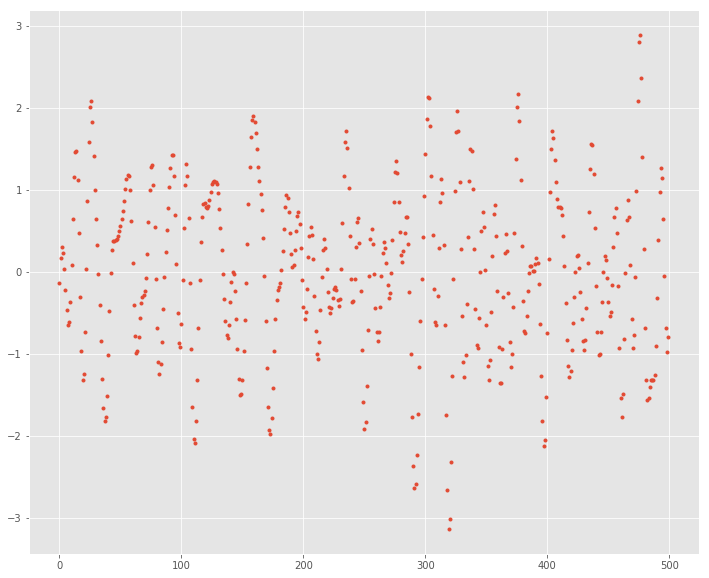

In [131]:
#Importing libraries. The same will be used throughout the article.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

#Define input array with angles from 60deg to 300deg converted to radians
#x = np.array([i*np.pi/180 for i in range(60,300,4)])
#np.random.seed(10)  #Setting seed for reproducability
#y = np.sin(x) + np.random.normal(0,0.15,len(x))

x,y=np.arange(TestClass.size[0]).reshape(-1,1),TestClass.data[:,0]

data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

In [132]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

In [133]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
data.head()


,x,y,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15
0,0.0,-0.140400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
1,1.0,0.171640,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
2,2.0,0.302040,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0,1024.0,2048.0,4096.0,8192.0,16384.0,3.276800e+04
3,3.0,0.232800,9.0,27.0,81.0,243.0,729.0,2187.0,6561.0,19683.0,59049.0,177147.0,531441.0,1594323.0,4782969.0,1.434891e+07
4,4.0,0.033853,16.0,64.0,256.0,1024.0,4096.0,16384.0,65536.0,262144.0,1048576.0,4194304.0,16777216.0,67108864.0,268435456.0,1.073742e+09


In [134]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

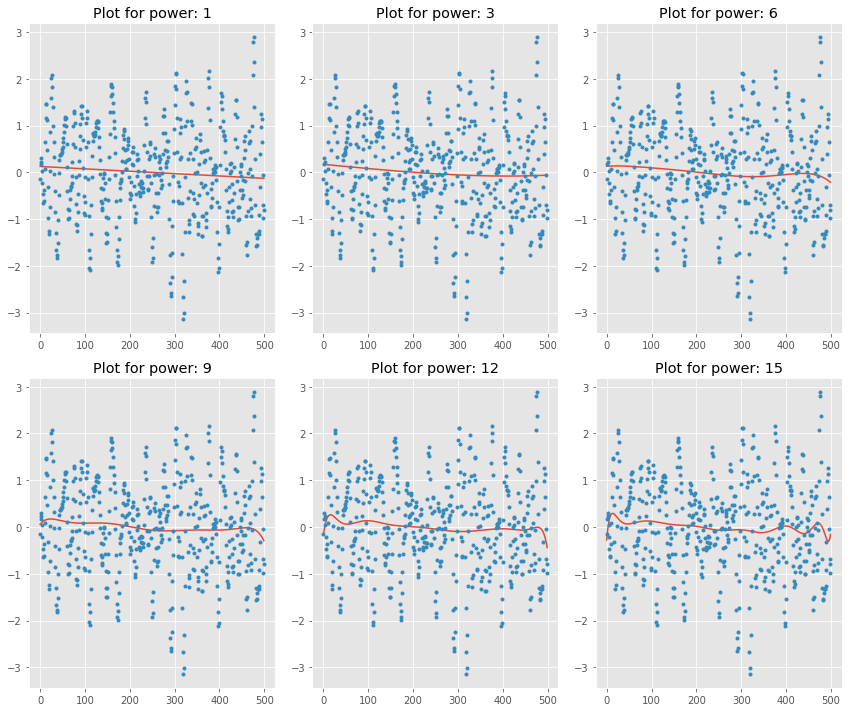

In [135]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

C:\Users\James Chapman\AppData\Roaming\Python\Python36\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.771467257462547e-17 / 1.1102230246251565e-16
  RuntimeWarning)


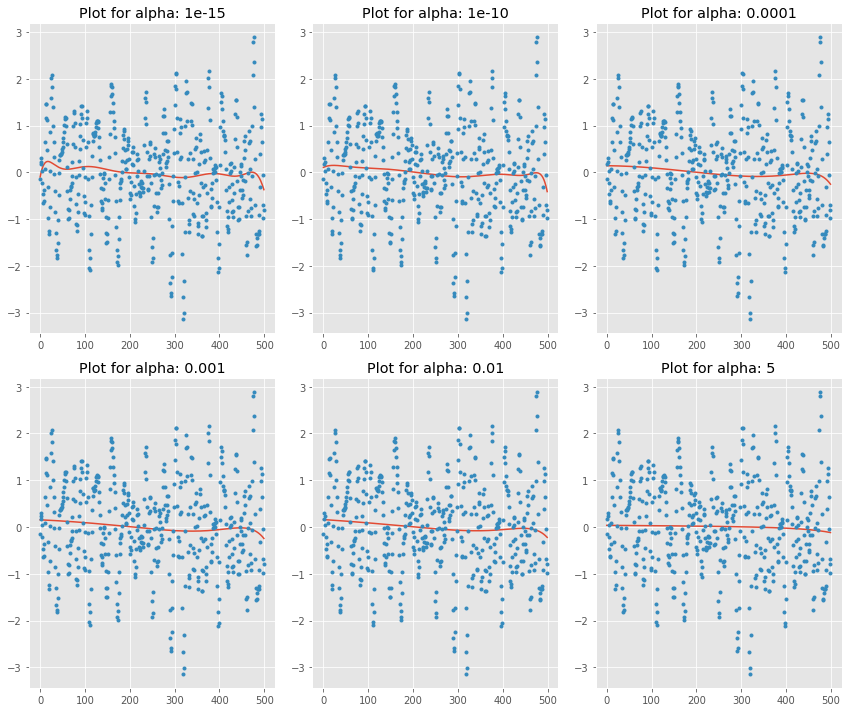

In [136]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

In [137]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,5e+02,0.13,-0.00051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,5e+02,0.18,-0.0012,1.4e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,5e+02,0.17,-0.00092,-2.5e-09,1.8e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,5e+02,0.1,0.0019,-2.5e-05,8.1e-08,-8e-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,5e+02,0.16,-0.0014,2.2e-05,-1.7e-07,4.9e-10,-4.6e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,5e+02,0.13,0.00076,-2.3e-05,1.9e-07,-8.5e-10,1.9e-12,-1.6e-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,5e+02,0.14,-0.0001,7.1e-07,-7.6e-08,5.9e-10,-2.3e-12,4.5e-15,-3.5e-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,5e+02,0.061,0.012,-0.00041,6e-06,-4.6e-08,1.9e-10,-4.5e-13,5.5e-16,-2.8e-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,5e+02,0.058,0.012,-0.00044,6.5e-06,-5e-08,2.1e-10,-5.2e-13,7e-16,-4.4e-19,7.2e-23,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,4.9e+02,-0.077,0.043,-0.0022,4.7e-05,-5.5e-07,3.8e-09,-1.7e-11,4.5e-14,-7.6e-17,7.1e-20,-2.8e-23,NaN,NaN,NaN,NaN,NaN


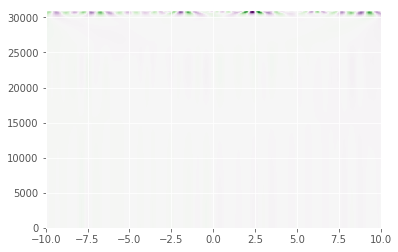

In [38]:

sig  = TestClass.data.T[3]
widths = np.arange(1, TestClass.size[0]+1)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-10, 10, 30, 31000], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\Users\James Chapman\AppData\Roaming\Python\Python36\site-packages\numpy\core\numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


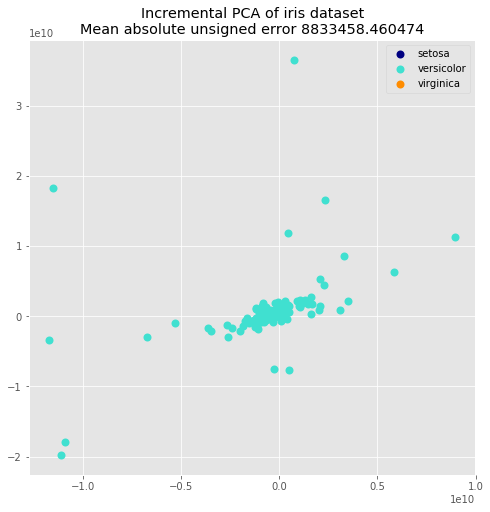

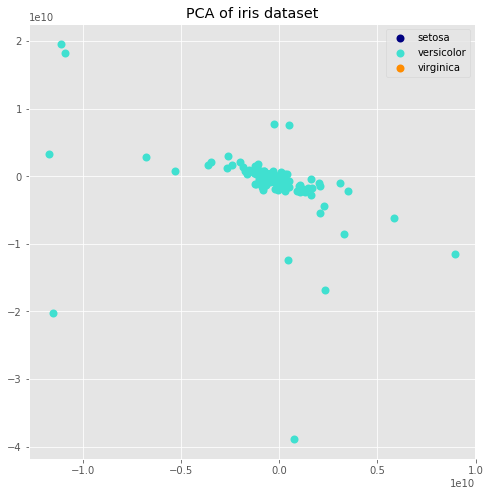

In [36]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, IncrementalPCA

X = TestClass.get_adjusted_fft_windowed()
y = TestClass.classes

n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=10)
X_ipca = ipca.fit_transform(X)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

colors = ['navy', 'turquoise', 'darkorange']

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
                    color=color, lw=2, label=target_name)

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error "
                  "%.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()

In [85]:
x1 = np.arange(1,10).reshape((3, 3))
x2 = np.arange(1,4.0)
np.multiply(x2, x1.T).T


array([[ 1.,  2.,  3.],
       [ 8., 10., 12.],
       [21., 24., 27.]])

In [92]:
(x1.T*x2).T

array([[ 1.,  2.,  3.],
       [ 8., 10., 12.],
       [21., 24., 27.]])